In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import torch
import random
import csv
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, RobustScaler
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from torchmetrics.classification import AUROC, Accuracy, ConfusionMatrix, F1Score
import os, subprocess, gc, time, datetime
from itertools import product

import models.models_original as models_original
import models.models_3d_atomics as new_models
from vasopressor.preprocess_helpers import load_and_create_MIMIC_dataloader
from models.helper import *
from models.param_initializations import *
from models.optimization_strategy import greedy_forward_selection, get_top_features_per_concept

gpu_id = int(subprocess.check_output('nvidia-smi --query-gpu=memory.free --format=csv,nounits,noheader | nl -v 0 | sort -nrk 2 | cut -f 1 | head -n 1 | xargs', shell=True, text=True))
device = torch.device(f'cuda:{gpu_id}') if torch.cuda.is_available else torch.device('cpu')
print("current device", device)

current device cuda:11


In [2]:
train_loader, val_loader, test_loader, class_weights, num_classes, changing_vars, static_names, seq_len = load_and_create_MIMIC_dataloader(output_dim = 2, batch_size = 512, random_state = 1)

print(class_weights, num_classes, seq_len)

for batch in train_loader:
    [print(t.shape, t.device) for t in batch]
    break

len(train_loader)

tensor([0.5797, 3.6376], dtype=torch.float64) 2 6
torch.Size([512, 6, 27]) cpu
torch.Size([512, 6, 27]) cpu
torch.Size([512, 8]) cpu
torch.Size([512, 2]) cpu


35

In [3]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, color="black", label="Train")
    plt.plot(val_losses, color="green", label="Val")
    plt.yscale("log")
    plt.legend()
    plt.show()

def plot_metrics(history, n_concepts_list):
    plt.plot(history[:, 0], history[:, 2], label=f'AUC')
    plt.plot(history[:, 0], history[:, 3], label=f'ACC')
    plt.plot(history[:, 0], history[:, 4], label=f'F1')

    plt.xlabel('Num Concepts')
    plt.ylabel('Criteria')
    plt.title('Plot of Concepts vs Criteria')
    plt.xticks(n_concepts_list)

    plt.legend()
    plt.show()

def plot_atomics_concepts_metric(history, title, dec="{:.3g}"):
        
    df = pd.DataFrame(history, columns=["n_atomics", "n_concepts", "val_loss", "auc", "acc", "f1"])
    mean_atomics = df.groupby("n_atomics").mean()
    mean_concepts = df.groupby("n_concepts").mean()

    # display(mean_atomics)
    plt.plot(mean_atomics.index, mean_atomics["auc"], label='AUC')
    plt.plot(mean_atomics.index, mean_atomics["acc"], label='ACC')
    plt.plot(mean_atomics.index, mean_atomics["f1"], label='F1')
    plt.xlabel('Num Atomics')
    plt.ylabel('Criteria')
    plt.title("Metric as mean over atomics")
    plt.suptitle(title)
    plt.legend()
    plt.show()

    # display(mean_concepts)
    plt.plot(mean_concepts.index, mean_concepts["auc"], label='AUC')
    plt.plot(mean_concepts.index, mean_concepts["acc"], label='ACC')
    plt.plot(mean_concepts.index, mean_concepts["f1"], label='F1')
    plt.xlabel('Num Concepts')
    plt.ylabel('Criteria')
    plt.title("Metric as mean over concepts")
    plt.suptitle(title)
    plt.legend()
    plt.show()


In [4]:
def initializeModel(n_concepts, static_dim, changing_dim, seq_len, output_dim, use_indicators, use_only_last_timestep, top_k=''):
    model = models_original.CBM(static_dim = static_dim, 
                                changing_dim = changing_dim, 
                                seq_len = seq_len,
                                num_concepts = n_concepts,
                                use_indicators = use_indicators,
                                use_only_last_timestep = use_only_last_timestep,
                                use_grad_norm = False,
                                use_multiplicative_interactions = False,
                                use_summaries = True,
                                opt_lr = 1e-3,
                                opt_weight_decay = 1e-5,
                                l1_lambda=1e-3,
                                cos_sim_lambda=1e-2,
                                output_dim = output_dim,
                                top_k=top_k,
                                device = device
                                )
    model = model.to(device)
    return model

def initializeModel_with_atomics(n_atomics, n_concepts, static_dim, changing_dim, seq_len, output_dim, use_summaries_for_atomics, use_indicators, top_k=''):
    model = new_models.CBM(static_dim = static_dim, 
                            changing_dim = changing_dim, 
                            seq_len = seq_len,
                            n_concepts = n_concepts,
                            n_atomics= n_atomics,
                            use_summaries_for_atomics = use_summaries_for_atomics,
                            use_indicators = use_indicators,
                            use_grad_norm = False,
                            use_summaries = True,
                            opt_lr = 1e-3,
                            opt_weight_decay = 1e-5,
                            l1_lambda=1e-3,
                            cos_sim_lambda=1e-2,
                            output_dim = output_dim,
                            top_k=top_k,
                            device = device
                            )
    model = model.to(device)
    return model


In [5]:
auroc_metric = AUROC(task="binary").to(device)
accuracy_metric = Accuracy(task="binary").to(device)
f1_metric = F1Score(task="binary").to(device)
conf_matrix = ConfusionMatrix(task="binary").to(device)

seq_len = seq_len
changing_dim = len(changing_vars)
static_dim = len(static_names)

print(changing_dim, static_dim, seq_len)


27 8 6


## Original

In [10]:
config_original = {
    "n_concepts": [4, 20],
    # "use_summaries": [True, False],
    "use_indicators": [True, False],
    "use_only_last_timestep": [True, False],
    # "use_grad_norm": [False, "FULL", "COMPONENT_WISE"],
}

all_config_permutations_og = list(product(*config_original.values()))
all_config_permutations_og = [dict(zip(config_original.keys(), permutation)) for permutation in all_config_permutations_og]
print(len(all_config_permutations_og))
# all_config_permutations_og

8


In [11]:
experiment_folder = "/workdir/optimal-summaries-public/_models/vasopressor/original_new/"
model_path = experiment_folder + "".join([f"{key}_{{{key}}}_" for key in config_original.keys()]) + "seed_{seed}.pt"

if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

In [12]:
random_seed = 1
set_seed(random_seed)

histories_original = []

for i, config in enumerate(all_config_permutations_og):
    print(i, config)
        
    train_loader, val_loader, test_loader, class_weights, num_classes, changing_vars, static_names, seq_len = load_and_create_MIMIC_dataloader(output_dim = 2, batch_size = 512, random_state = random_seed)
    
    model = initializeModel(**config, static_dim=static_dim, changing_dim=changing_dim, seq_len=seq_len, output_dim=2)
    model.fit(train_loader, val_loader, p_weight=class_weights.to(device), save_model_path=model_path.format(**config, seed = random_seed), max_epochs=10000)
    
    auc, acc, f1 = evaluate_classification(model, test_loader, num_classes=num_classes, device=device)
    
    history = ["original", i, model.val_losses[-1], auc, acc, f1]
    print(history)
    histories_original.append(np.array(history))
    
    # plot_losses(model.train_losses, model.val_losses)
    del model
    gc.collect()
    torch.cuda.empty_cache()
    
histories_original = np.array(histories_original)
histories_original.shape


0 {'n_concepts': 4, 'use_indicators': True, 'use_only_last_timestep': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  0%|          | 29/10000 [00:25<2:08:14,  1.30 epoch/s, Train Loss=0.53029, Val Loss=0.55907, Best Val Loss=0.55907]

  5%|▍         | 470/10000 [06:13<2:06:08,  1.26 epoch/s, Train Loss=0.47966, Val Loss=0.52142, Best Val Loss=0.52028]

Early Stopped


['original', 0, 0.5219928026199341, 0.9177289009094238, 0.8444311022758484, 0.8511860966682434]
1 {'n_concepts': 4, 'use_indicators': True, 'use_only_last_timestep': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  4%|▎         | 350/10000 [05:06<2:21:02,  1.14 epoch/s, Train Loss=0.48052, Val Loss=0.52560, Best Val Loss=0.52309]

Early Stopped


['original', 1, 0.5268927812576294, 0.9094090461730957, 0.8297580480575562, 0.8381729125976562]
2 {'n_concepts': 4, 'use_indicators': False, 'use_only_last_timestep': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  5%|▍         | 470/10000 [06:27<2:11:07,  1.21 epoch/s, Train Loss=0.48244, Val Loss=0.52327, Best Val Loss=0.52287]

Early Stopped


['original', 2, 0.524680495262146, 0.9136213064193726, 0.8398833274841309, 0.8469237089157104]
3 {'n_concepts': 4, 'use_indicators': False, 'use_only_last_timestep': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  3%|▎         | 330/10000 [04:33<2:13:30,  1.21 epoch/s, Train Loss=0.48456, Val Loss=0.52879, Best Val Loss=0.52501]

Early Stopped


['original', 3, 0.5256660580635071, 0.9098008275032043, 0.8346490263938904, 0.8425010442733765]
4 {'n_concepts': 20, 'use_indicators': True, 'use_only_last_timestep': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  3%|▎         | 320/10000 [04:47<2:24:51,  1.11 epoch/s, Train Loss=0.49050, Val Loss=0.53619, Best Val Loss=0.53358]

Early Stopped


['original', 4, 0.5337627530097961, 0.9183107614517212, 0.8453750014305115, 0.8525850772857666]
5 {'n_concepts': 20, 'use_indicators': True, 'use_only_last_timestep': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  3%|▎         | 340/10000 [05:04<2:24:16,  1.12 epoch/s, Train Loss=0.48686, Val Loss=0.54045, Best Val Loss=0.53711]

Early Stopped


['original', 5, 0.5406580567359924, 0.9160631895065308, 0.8389394283294678, 0.8468379974365234]
6 {'n_concepts': 20, 'use_indicators': False, 'use_only_last_timestep': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  5%|▍         | 460/10000 [06:24<2:12:52,  1.20 epoch/s, Train Loss=0.48892, Val Loss=0.53394, Best Val Loss=0.53161]

Early Stopped


['original', 6, 0.5328332185745239, 0.9193722009658813, 0.8505234122276306, 0.8564600944519043]
7 {'n_concepts': 20, 'use_indicators': False, 'use_only_last_timestep': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  4%|▍         | 440/10000 [06:03<2:11:34,  1.21 epoch/s, Train Loss=0.49342, Val Loss=0.54194, Best Val Loss=0.53214]

Early Stopped


['original', 7, 0.5374981164932251, 0.9175485968589783, 0.8435730338096619, 0.8510012030601501]


(8, 6)

In [ ]:
# plot
# plot_metrics(histories_original, n_concepts_list)


## Atomics

In [13]:
config_atomics = {
    "n_atomics": [10, 30], # 30
    "n_concepts": [4, 20], # 20
    "use_indicators": [True, False],
    "use_summaries_for_atomics": [True, False],
    # "use_grad_norm": [False, "FULL", "COMPONENT_WISE"],
}

all_config_permutations_atomics = list(product(*config_atomics.values()))
all_config_permutations_atomics = [dict(zip(config_atomics.keys(), permutation)) for permutation in all_config_permutations_atomics]
print(len(all_config_permutations_atomics))
# all_config_permutations_atomics

16


In [14]:
experiment_folder = "/workdir/optimal-summaries-public/_models/vasopressor/atomics_new/"
model_path = experiment_folder + "".join([f"{key}_{{{key}}}_" for key in config_atomics.keys()]) + "seed_{seed}.pt"

if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

In [15]:
random_seed = 1
set_seed(random_seed)

history_atomics = []

for i, config in enumerate(all_config_permutations_atomics):
    print(i, config)
    
    train_loader, val_loader, test_loader, class_weights, num_classes, changing_vars, static_names, seq_len = load_and_create_MIMIC_dataloader(output_dim = 2, batch_size = 512, random_state = random_seed)
    
    model = initializeModel_with_atomics(**config, static_dim=static_dim, changing_dim=changing_dim, seq_len=seq_len, output_dim=2)
    model.fit(train_loader, val_loader, p_weight=class_weights.to(device), save_model_path=model_path.format(**config, seed = random_seed), max_epochs=10000)
    
    auc, acc, f1 = evaluate_classification(model, test_loader, num_classes=num_classes, device=device)

    history = ["atomics", i, model.val_losses[-1], auc, acc, f1]
    print(history)
    history_atomics.append(np.array(history))
    
    # plot_losses(model.train_losses, model.val_losses)
    del model
    gc.collect()
    torch.cuda.empty_cache()

    
history_atomics = np.array(history_atomics)
history_atomics.shape


0 {'n_atomics': 10, 'n_concepts': 4, 'use_indicators': True, 'use_summaries_for_atomics': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  1%|          | 71/10000 [01:15<3:22:12,  1.22s/ epoch, Train Loss=0.56480, Val Loss=0.58068, Best Val Loss=0.58068]

  9%|▉         | 910/10000 [15:31<2:35:00,  1.02s/ epoch, Train Loss=0.49863, Val Loss=0.53715, Best Val Loss=0.53624]

Early Stopped


AUC macro 0.9173021912574768
ACC macro 0.8436588048934937
 F1 macro 0.8508513569831848
['atomics', 0, 0.536270022392273, 0.9173021912574768, 0.8436588048934937, 0.8508513569831848]
1 {'n_atomics': 10, 'n_concepts': 4, 'use_indicators': True, 'use_summaries_for_atomics': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  2%|▏         | 230/10000 [03:39<2:35:30,  1.05 epoch/s, Train Loss=0.56757, Val Loss=0.58153, Best Val Loss=0.57967]

Early Stopped


AUC macro 0.8971583247184753
ACC macro 0.8594474196434021
 F1 macro 0.8634316921234131
['atomics', 1, 0.5811946988105774, 0.8971583247184753, 0.8594474196434021, 0.8634316921234131]
2 {'n_atomics': 10, 'n_concepts': 4, 'use_indicators': False, 'use_summaries_for_atomics': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
 10%|▉         | 970/10000 [14:04<2:11:01,  1.15 epoch/s, Train Loss=0.49621, Val Loss=0.53379, Best Val Loss=0.53315]

Early Stopped


AUC macro 0.9152399301528931
ACC macro 0.838424563407898
 F1 macro 0.8462731838226318
['atomics', 2, 0.5334510803222656, 0.9152399301528931, 0.838424563407898, 0.8462731838226318]
3 {'n_atomics': 10, 'n_concepts': 4, 'use_indicators': False, 'use_summaries_for_atomics': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  3%|▎         | 270/10000 [03:58<2:23:05,  1.13 epoch/s, Train Loss=0.61317, Val Loss=0.63057, Best Val Loss=0.62162]

Early Stopped


AUC macro 0.899911642074585
ACC macro 0.8501802086830139
 F1 macro 0.8554635643959045
['atomics', 3, 0.6298741102218628, 0.899911642074585, 0.8501802086830139, 0.8554635643959045]
4 {'n_atomics': 10, 'n_concepts': 20, 'use_indicators': True, 'use_summaries_for_atomics': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
 14%|█▍        | 1400/10000 [23:22<2:23:35,  1.00s/ epoch, Train Loss=0.50775, Val Loss=0.54345, Best Val Loss=0.54077]

Early Stopped


AUC macro 0.9142311811447144
ACC macro 0.8372232913970947
 F1 macro 0.844597339630127
['atomics', 4, 0.5408491492271423, 0.9142311811447144, 0.8372232913970947, 0.844597339630127]
5 {'n_atomics': 10, 'n_concepts': 20, 'use_indicators': True, 'use_summaries_for_atomics': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  2%|▏         | 220/10000 [03:55<2:54:17,  1.07s/ epoch, Train Loss=0.57576, Val Loss=0.59155, Best Val Loss=0.58801]

Early Stopped


AUC macro 0.8969228267669678
ACC macro 0.834477424621582
 F1 macro 0.8431834578514099
['atomics', 5, 0.5993070602416992, 0.8969228267669678, 0.834477424621582, 0.8431834578514099]
6 {'n_atomics': 10, 'n_concepts': 20, 'use_indicators': False, 'use_summaries_for_atomics': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
 10%|▉         | 990/10000 [16:24<2:29:19,  1.01 epoch/s, Train Loss=0.50889, Val Loss=0.54181, Best Val Loss=0.54078]

Early Stopped


AUC macro 0.9181017279624939
ACC macro 0.8423717021942139
 F1 macro 0.8499550819396973
['atomics', 6, 0.5421457290649414, 0.9181017279624939, 0.8423717021942139, 0.8499550819396973]
7 {'n_atomics': 10, 'n_concepts': 20, 'use_indicators': False, 'use_summaries_for_atomics': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  5%|▍         | 460/10000 [06:48<2:21:05,  1.13 epoch/s, Train Loss=0.60289, Val Loss=0.63277, Best Val Loss=0.62265]

Early Stopped


AUC macro 0.9079630374908447
ACC macro 0.8525828123092651
 F1 macro 0.8577579259872437
['atomics', 7, 0.6245154738426208, 0.9079630374908447, 0.8525828123092651, 0.8577579259872437]
8 {'n_atomics': 30, 'n_concepts': 4, 'use_indicators': True, 'use_summaries_for_atomics': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
 11%|█▏        | 1140/10000 [17:50<2:18:37,  1.07 epoch/s, Train Loss=0.50623, Val Loss=0.55207, Best Val Loss=0.54268]

Early Stopped


AUC macro 0.9203840494155884
ACC macro 0.8492363095283508
 F1 macro 0.8556878566741943
['atomics', 8, 0.5456638336181641, 0.9203840494155884, 0.8492363095283508, 0.8556878566741943]
9 {'n_atomics': 30, 'n_concepts': 4, 'use_indicators': True, 'use_summaries_for_atomics': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  2%|▏         | 210/10000 [03:19<2:34:38,  1.06 epoch/s, Train Loss=0.81836, Val Loss=0.86292, Best Val Loss=0.84042]

Early Stopped


AUC macro 0.8967030644416809
ACC macro 0.8415136337280273
 F1 macro 0.849482536315918
['atomics', 9, 0.8492011427879333, 0.8967030644416809, 0.8415136337280273, 0.849482536315918]
10 {'n_atomics': 30, 'n_concepts': 4, 'use_indicators': False, 'use_summaries_for_atomics': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
 10%|█         | 1030/10000 [15:04<2:11:16,  1.14 epoch/s, Train Loss=0.61808, Val Loss=0.65230, Best Val Loss=0.65167]

Early Stopped


AUC macro 0.9188683032989502
ACC macro 0.8428007364273071
 F1 macro 0.85017991065979
['atomics', 10, 0.653633177280426, 0.9188683032989502, 0.8428007364273071, 0.85017991065979]
11 {'n_atomics': 30, 'n_concepts': 4, 'use_indicators': False, 'use_summaries_for_atomics': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  6%|▌         | 570/10000 [08:16<2:16:58,  1.15 epoch/s, Train Loss=1.19163, Val Loss=1.22476, Best Val Loss=1.22149]

Early Stopped


AUC macro 0.9008169770240784
ACC macro 0.8452891707420349
 F1 macro 0.8522494435310364
['atomics', 11, 1.2231030464172363, 0.9008169770240784, 0.8452891707420349, 0.8522494435310364]
12 {'n_atomics': 30, 'n_concepts': 20, 'use_indicators': True, 'use_summaries_for_atomics': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  8%|▊         | 760/10000 [11:53<2:24:29,  1.07 epoch/s, Train Loss=0.52282, Val Loss=0.55078, Best Val Loss=0.55028]

Early Stopped


AUC macro 0.91743004322052
ACC macro 0.8424575328826904
 F1 macro 0.8494588136672974
['atomics', 12, 0.5520872473716736, 0.91743004322052, 0.8424575328826904, 0.8494588136672974]
13 {'n_atomics': 30, 'n_concepts': 20, 'use_indicators': True, 'use_summaries_for_atomics': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  3%|▎         | 340/10000 [05:16<2:29:57,  1.07 epoch/s, Train Loss=0.82922, Val Loss=0.85497, Best Val Loss=0.85279]

Early Stopped


AUC macro 0.8992177844047546
ACC macro 0.838167130947113
 F1 macro 0.8439258337020874
['atomics', 13, 0.8561632037162781, 0.8992177844047546, 0.838167130947113, 0.8439258337020874]
14 {'n_atomics': 30, 'n_concepts': 20, 'use_indicators': False, 'use_summaries_for_atomics': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
 14%|█▎        | 1370/10000 [20:03<2:06:19,  1.14 epoch/s, Train Loss=0.61604, Val Loss=0.65261, Best Val Loss=0.64746]

Early Stopped


AUC macro 0.9128479957580566
ACC macro 0.8339625597000122
 F1 macro 0.8422340154647827
['atomics', 14, 0.6477808952331543, 0.9128479957580566, 0.8339625597000122, 0.8422340154647827]
15 {'n_atomics': 30, 'n_concepts': 20, 'use_indicators': False, 'use_summaries_for_atomics': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  3%|▎         | 290/10000 [04:13<2:21:34,  1.14 epoch/s, Train Loss=1.19448, Val Loss=1.22297, Best Val Loss=1.21586]

Early Stopped


AUC macro 0.904352068901062
ACC macro 0.8489788770675659
 F1 macro 0.8550008535385132
['atomics', 15, 1.2273125648498535, 0.904352068901062, 0.8489788770675659, 0.8550008535385132]


(16, 6)

In [14]:
columns = ["type", "config", "val_loss", "auc", "acc", "f1"]
dtypes = {'type': str, 'config': int, 'val_loss': float, 'auc': float, 'acc': float, 'f1': float}

df_og = pd.DataFrame(histories_original, columns=columns).astype(dtypes)
df_og = df_og.join(pd.DataFrame(all_config_permutations_og), on="config", how="left")

df_atomics = pd.DataFrame(history_atomics, columns=columns).astype(dtypes)
df_atomics = df_atomics.join(pd.DataFrame(all_config_permutations_atomics), on="config", how="left")

result_df = pd.concat([df_og, df_atomics], ignore_index=True)
result_df


,type,config,val_loss,auc,acc,f1,n_concepts,use_indicators,use_fixes,use_only_last_timestep,n_atomics,use_summaries_for_atomics
0,original,0,0.519994,0.911697,0.831989,0.840528,4,True,False,True,NaN,NaN
1,original,1,0.522041,0.916421,0.837910,0.845909,4,True,False,False,NaN,NaN
2,original,2,0.517659,0.912625,0.834392,0.842834,4,True,True,True,NaN,NaN
3,original,3,0.517217,0.912472,0.839797,0.847130,4,True,True,False,NaN,NaN
4,original,4,0.523946,0.912431,0.833705,0.841121,4,False,False,True,NaN,NaN
5,original,5,0.532511,0.913204,0.837738,0.845190,4,False,False,False,NaN,NaN
6,original,6,0.522208,0.911759,0.835593,0.843694,4,False,True,True,NaN,NaN
7,original,7,0.525868,0.917177,0.843659,0.851095,4,False,True,False,NaN,NaN
8,original,8,0.529575,0.913147,0.837223,0.845383,20,True,False,True,NaN,NaN
9,original,9,0.533516,0.915003,0.837395,0.844990,20,True,False,False,NaN,NaN


In [15]:
for col in result_df.columns[3:6]:
    baseline = result_df[(result_df['type'] == 'original') & (result_df['config'] == 0)][col].values[0]
    print(col, baseline)
    result_df[f'{col}_abs_imp'] = result_df[col] - baseline
    # result_df[f'{col}_rel_imp'] = result_df[f'{col}_abs_imp'] / baseline
# result_df

auc 0.9116973876953125
acc 0.8319889903068542
f1 0.8405277729034424


In [16]:
pd.set_option('display.max_rows', 20)
result_df.sort_values(by='acc', ascending=False)
# atomics: atomics, concepts, use_indicators, use_fixes, output_dim, use_summaries_for_atomics
# original: concepts, use_indicators, use_fixes, output_dim, use_only_last_timestep


,type,config,val_loss,auc,acc,f1,n_concepts,use_indicators,use_fixes,use_only_last_timestep,n_atomics,use_summaries_for_atomics,auc_abs_imp,acc_abs_imp,f1_abs_imp
45,atomics,29,1.207552,0.902763,0.860563,0.864595,20,False,False,NaN,30.0,False,-0.008935,0.028574,0.024067
25,atomics,9,0.591889,0.905936,0.858246,0.862034,20,True,False,NaN,10.0,False,-0.005761,0.026257,0.021507
23,atomics,7,0.623894,0.905699,0.857302,0.860709,4,False,True,NaN,10.0,False,-0.005998,0.025313,0.020181
21,atomics,5,0.623107,0.900487,0.855329,0.859710,4,False,False,NaN,10.0,False,-0.011211,0.023340,0.019183
41,atomics,25,0.861831,0.895952,0.853612,0.856999,20,True,False,NaN,30.0,False,-0.015745,0.021623,0.016471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,atomics,12,0.541652,0.908697,0.829243,0.838053,20,False,False,NaN,10.0,True,-0.003000,-0.002746,-0.002474
46,atomics,30,0.658543,0.907511,0.828986,0.837505,20,False,True,NaN,30.0,True,-0.004186,-0.003003,-0.003023
17,atomics,1,0.572459,0.902001,0.827784,0.833098,4,True,False,NaN,10.0,False,-0.009697,-0.004205,-0.007430
38,atomics,22,0.651017,0.898820,0.814913,0.825245,4,False,True,NaN,30.0,True,-0.012877,-0.017076,-0.015283


In [17]:
for key in sorted(set(list(all_config_permutations_og[0].keys()) + list(all_config_permutations_atomics[0].keys()))):
    display(result_df.groupby(["type", key], dropna=False)[["auc", "acc", "f1"]].mean())

display(result_df.groupby("type")[["auc", "acc", "f1"]].mean())

auc       acc        f1
type     n_atomics                              
atomics  10.0       0.908806  0.842522  0.849269
         30.0       0.907250  0.840650  0.847580
original NaN        0.913018  0.836859  0.844611

auc       acc        f1
type     n_concepts                              
atomics  4           0.907722  0.839288  0.846169
         20          0.908334  0.843884  0.850680
original 4           0.913473  0.836848  0.844688
         20          0.912563  0.836869  0.844535

auc       acc        f1
type     use_fixes                              
atomics  False      0.909518  0.846367  0.852367
         True       0.906538  0.836805  0.844482
original False      0.912165  0.835164  0.843088
         True       0.913872  0.838553  0.846135

auc       acc        f1
type     use_indicators                              
atomics  False           0.908218  0.842500  0.849396
         True            0.907838  0.840672  0.847452
original False           0.912190  0.836376  0.844116
         True            0.913846  0.837341  0.845107

auc       acc        f1
type     use_only_last_timestep                              
atomics  NaN                     0.908028  0.841586  0.848424
original False                   0.914382  0.838628  0.846124
         True                    0.911655  0.835089  0.843099

auc       acc        f1
type     use_summaries_for_atomics                              
atomics  False                      0.900692  0.842715  0.849024
         True                       0.915364  0.840457  0.847825
original NaN                        0.913018  0.836859  0.844611

,auc,acc,f1
type,,,
atomics,0.908028,0.841586,0.848424
original,0.913018,0.836859,0.844611


## Optimization

In [33]:
# feature weights
config_original = {
    "n_concepts": 4,
    "use_indicators": True,
    "use_fixes": False,
    "use_only_last_timestep": True,
    "use_grad_norm": False,
}

experiment_folder = "/workdir/optimal-summaries-public/_models/vasopressor/original/"
model_path = experiment_folder + "".join([f"{key}_{{{key}}}_" for key in config_original.keys()]) + "seed_{seed}.pt"

train_loader, val_loader, test_loader, class_weights, num_classes, changing_vars, static_names, seq_len = load_and_create_MIMIC_dataloader(output_dim = 2, batch_size = 512, random_state = random_seed)

top_k_file = "" # "/workdir/optimal-summaries-public/_models/vasopressor/original/top-k/bottleneck_topkinds.csv"

model = initializeModel(**config_original, static_dim=static_dim, changing_dim=changing_dim, seq_len=seq_len, output_dim=2, top_k=top_k_file)
model.fit(train_loader, val_loader, p_weight=class_weights.to(device), save_model_path=model_path.format(**config_original, seed = random_seed), max_epochs=10000)

for batch in test_loader:
    *data, y = extract_to(batch, device)
    probs = model(*data)

    auc = auroc_metric(probs, y).item()
    acc = accuracy_metric(probs, y).item()
    f1 = f1_metric(probs, y).item()

auc = auroc_metric.compute().item()
acc = accuracy_metric.compute().item()
f1 = f1_metric.compute().item()

auroc_metric.reset()
accuracy_metric.reset()
f1_metric.reset()

print("AUC", auc)
print("ACC", acc)
print("F1", f1)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/vaso_c4_indTrue_fixesFalse_onlylasttimestepTrue_output_dim2_gradnormFalse.pt
AUC 0.9174805283546448
ACC 0.5
F1 0.6666666865348816


In [25]:
model.bottleneck.weight

Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:8', requires_grad=True)

In [26]:
abs_bottleneck_weights = model.bottleneck.weight.cpu().detach().numpy()
abs_bottleneck_weights = np.abs(abs_bottleneck_weights)
abs_bottleneck_weights.shape


(4, 386)

In [27]:
(abs_bottleneck_weights == 0).sum() == 4*386

True

In [20]:
threshold = 1e-4  # Threshold value

# Iterate over each row (dimension)
for row_idx in range(abs_bottleneck_weights.shape[0]):
    # Select weights bigger than the threshold for the current row
    selected_weights = abs_bottleneck_weights[row_idx][abs_bottleneck_weights[row_idx] < threshold]
    
    # Print the selected weights for the current row
    print(f"Row {row_idx + 1}: Selected weights smaller than threshold ({threshold}):")
    # print(selected_weights)
    print(len(selected_weights))


Row 1: Selected weights smaller than threshold (0.0001):
386
Row 2: Selected weights smaller than threshold (0.0001):
386
Row 3: Selected weights smaller than threshold (0.0001):
386
Row 4: Selected weights smaller than threshold (0.0001):
386


/tmp/ipykernel_3812583/4283319824.py:11: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0, max_y)


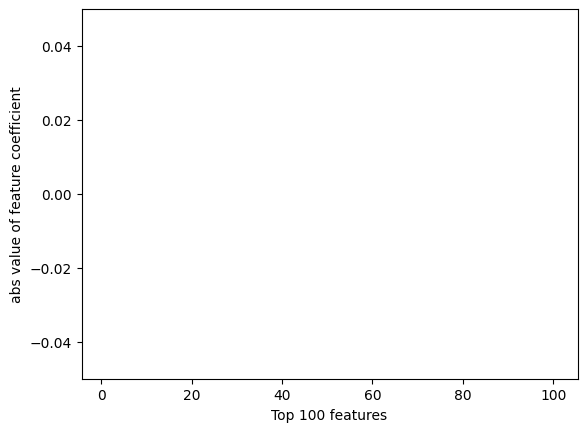

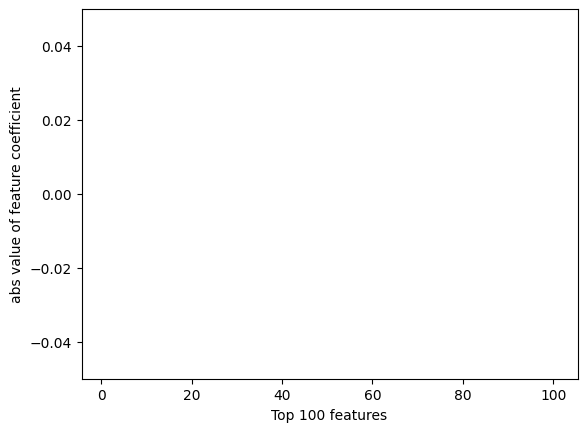

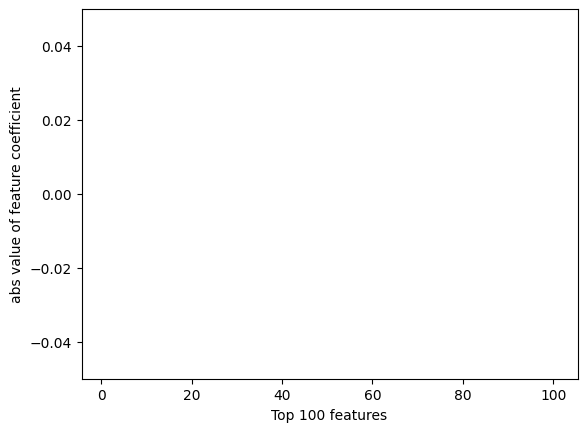

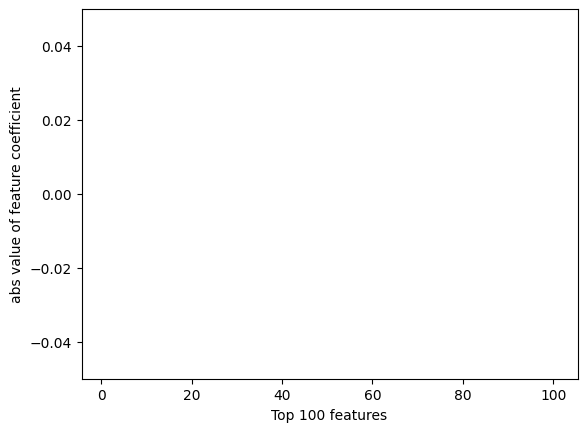

In [21]:
# visualize weight magnitudes
max_y = np.max(abs_bottleneck_weights)

for c in range(abs_bottleneck_weights.shape[0]):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    inds = np.argsort(-abs_bottleneck_weights[c])[:100]
    ax.bar(np.arange(1,101), abs_bottleneck_weights[c][inds])
    ax.set_xlabel("Top 100 features")
    ax.set_ylabel("abs value of feature coefficient")
    ax.set_ylim(0, max_y)
    plt.show()


In [10]:
top_k_inds = get_top_features_per_concept(model.bottleneck)
# top_k_inds
model.linear.weight

Found 4 Concepts
90th percentile per concept [6.4518924 0.6162137 1.6398425 6.4495716]
['Concept 0 len: 37', 'Concept 1 len: 141', 'Concept 2 len: 94', 'Concept 3 len: 45']


Parameter containing:
tensor([[-3.6567, -0.8923,  1.6247,  3.6836],
        [ 3.6758,  0.9358, -1.5211, -3.7086]], device='cuda:14',
       requires_grad=True)

In [ ]:
# write top k inds to csv
top_k_file = experiment_folder + "top-k/top_k_idx.csv"

directory = os.path.dirname(top_k_file)
if not os.path.exists(directory):
    os.makedirs(directory)

# writing to csv file 
with open(top_k_file, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)
    # writing the data rows 
    csvwriter.writerows(top_k_inds)


In [ ]:
V = 13 + 1
T = seq_len + 1
print(T)
vars_ = [i for i in range(1,V)] + [str(i) + "_ind" for i in range(1,V)]
print(len(vars_))
data_cols = [["feat_{}_time_{}".format(v, t) for v in vars_] for t in range(1, T)]
flattened_data_cols = [col for sublist in data_cols for col in sublist]
print(len(flattened_data_cols))
flattened_data_cols

In [ ]:

for c, _list in enumerate(top_k_inds):
    for ind in _list:
        name, summary = getConcept(flattened_data_cols, input_dim, changing_dim, int(ind))
        print(f"Concept {c}: ID {ind}, Feature {name}, Summary {summary}")


In [11]:
track_metrics={"acc": accuracy_metric,
               "f1": f1_metric,
               }

greedy_results = greedy_forward_selection(model=model, layers_to_prune=[model.bottleneck], top_k_inds=[top_k_inds], val_loader=val_loader, optimize_metric=auroc_metric, device=device, track_metrics=track_metrics)
#greedy_results


  0%|          | 0/40 [00:00<?, ?it/s]

0.9043956995010376 0 1 159


  2%|▎         | 1/40 [02:35<1:41:23, 155.99s/it, Score=0.90440, acc=0.5, f1=0.667]

0.9101836681365967 0 1 383


  5%|▌         | 2/40 [05:19<1:41:30, 160.27s/it, Score=0.91018, acc=0.5, f1=0.667]

0.912787139415741 0 1 66


  8%|▊         | 3/40 [08:01<1:39:30, 161.35s/it, Score=0.91279, acc=0.5, f1=0.667]

0.9146532416343689 0 1 165


 10%|█         | 4/40 [10:40<1:36:14, 160.40s/it, Score=0.91465, acc=0.5, f1=0.667]

0.9162225723266602 0 1 374


 12%|█▎        | 5/40 [13:14<1:32:04, 157.86s/it, Score=0.91622, acc=0.5, f1=0.667]

0.9167425632476807 0 1 124


 15%|█▌        | 6/40 [15:48<1:28:42, 156.56s/it, Score=0.91674, acc=0.5, f1=0.667]

0.9172939658164978 0 1 254


 18%|█▊        | 7/40 [18:21<1:25:36, 155.64s/it, Score=0.91729, acc=0.5, f1=0.667]

0.9176132678985596 0 1 75


 20%|██        | 8/40 [20:55<1:22:37, 154.93s/it, Score=0.91761, acc=0.5, f1=0.667]

0.917834997177124 0 1 44


 22%|██▎       | 9/40 [23:25<1:19:19, 153.52s/it, Score=0.91783, acc=0.5, f1=0.667]

0.9179750680923462 0 1 163


 25%|██▌       | 10/40 [25:58<1:16:40, 153.36s/it, Score=0.91798, acc=0.5, f1=0.667]

0.9180300831794739 0 1 79


 28%|██▊       | 11/40 [28:30<1:13:52, 152.84s/it, Score=0.91803, acc=0.5, f1=0.667]

0.9178865551948547 0 1 160


 30%|███       | 12/40 [31:02<1:11:16, 152.72s/it, Score=0.91789, acc=0.5, f1=0.667]

0.9177618026733398 0 1 233


 32%|███▎      | 13/40 [33:32<1:08:19, 151.82s/it, Score=0.91776, acc=0.5, f1=0.667]

0.9176356792449951 0 1 298


 35%|███▌      | 14/40 [36:02<1:05:31, 151.19s/it, Score=0.91764, acc=0.5, f1=0.667]

0.9175627827644348 0 1 149


 38%|███▊      | 15/40 [38:33<1:03:01, 151.27s/it, Score=0.91756, acc=0.5, f1=0.667]

0.9174972772598267 0 1 132


 40%|████      | 16/40 [41:03<1:00:15, 150.65s/it, Score=0.91750, acc=0.5, f1=0.667]

0.9175880551338196 0 1 291


 42%|████▎     | 17/40 [43:29<57:16, 149.39s/it, Score=0.91759, acc=0.5, f1=0.667]  

0.9177529215812683 0 1 325


 45%|████▌     | 18/40 [45:59<54:53, 149.69s/it, Score=0.91775, acc=0.5, f1=0.667]

0.9178279042243958 0 1 282


 48%|████▊     | 19/40 [48:29<52:21, 149.58s/it, Score=0.91783, acc=0.5, f1=0.667]

0.9178329706192017 0 1 213


 50%|█████     | 20/40 [51:02<50:15, 150.77s/it, Score=0.91783, acc=0.5, f1=0.667]

0.9178073406219482 0 1 360


 52%|█████▎    | 21/40 [53:43<48:43, 153.88s/it, Score=0.91781, acc=0.5, f1=0.667]

0.917824923992157 0 1 365


 55%|█████▌    | 22/40 [56:24<46:45, 155.89s/it, Score=0.91782, acc=0.5, f1=0.667]

0.9178632497787476 0 1 350


 57%|█████▊    | 23/40 [59:03<44:24, 156.73s/it, Score=0.91786, acc=0.5, f1=0.667]

0.9179596900939941 0 1 162


 60%|██████    | 24/40 [1:01:45<42:15, 158.47s/it, Score=0.91796, acc=0.5, f1=0.667]

0.9179086089134216 0 1 37


 62%|██████▎   | 25/40 [1:04:21<39:23, 157.59s/it, Score=0.91791, acc=0.5, f1=0.667]

0.9178296327590942 0 1 133


 65%|██████▌   | 26/40 [1:06:54<36:28, 156.35s/it, Score=0.91783, acc=0.5, f1=0.667]

0.9178916811943054 0 1 54


 68%|██████▊   | 27/40 [1:09:29<33:48, 156.01s/it, Score=0.91789, acc=0.5, f1=0.667]

0.9183753728866577 0 2 159


 70%|███████   | 28/40 [1:12:04<31:06, 155.57s/it, Score=0.91838, acc=0.5, f1=0.667]

0.9185553789138794 0 1 16


 72%|███████▎  | 29/40 [1:14:36<28:21, 154.64s/it, Score=0.91856, acc=0.5, f1=0.667]

0.9186737537384033 0 1 57


 75%|███████▌  | 30/40 [1:17:42<27:20, 164.06s/it, Score=0.91867, acc=0.5, f1=0.667]

0.9187848567962646 0 1 251


 78%|███████▊  | 31/40 [1:21:12<26:39, 177.70s/it, Score=0.91878, acc=0.5, f1=0.667]

0.9187843799591064 0 1 47


 80%|████████  | 32/40 [1:23:49<22:51, 171.50s/it, Score=0.91878, acc=0.5, f1=0.667]

0.9187599420547485 0 1 214


 82%|████████▎ | 33/40 [1:26:22<19:22, 166.09s/it, Score=0.91876, acc=0.5, f1=0.667]

0.9187129735946655 0 1 136


 85%|████████▌ | 34/40 [1:28:55<16:11, 161.89s/it, Score=0.91871, acc=0.5, f1=0.667]

0.9186376333236694 0 1 384


 88%|████████▊ | 35/40 [1:31:29<13:18, 159.68s/it, Score=0.91864, acc=0.5, f1=0.667]

0.9186025261878967 0 1 324


 90%|█████████ | 36/40 [1:33:59<10:27, 156.85s/it, Score=0.91860, acc=0.5, f1=0.667]

0.9185426235198975 0 1 156


 92%|█████████▎| 37/40 [1:36:30<07:45, 155.14s/it, Score=0.91854, acc=0.5, f1=0.667]

0.9184754490852356 0 1 205


 95%|█████████▌| 38/40 [1:39:03<05:08, 154.34s/it, Score=0.91848, acc=0.5, f1=0.667]

0.9184189438819885 0 1 335


 98%|█████████▊| 39/40 [1:41:35<02:33, 153.57s/it, Score=0.91842, acc=0.5, f1=0.667]

0.918387234210968 0 1 207


100%|██████████| 40/40 [1:44:01<00:00, 156.03s/it, Score=0.91839, acc=0.5, f1=0.667]


In [12]:
greedy_results

,Score,Layer,Concept,Feature,acc,f1
0,0.904396,0,1,159,0.5,0.666667
1,0.910184,0,1,383,0.5,0.666667
2,0.912787,0,1,66,0.5,0.666667
3,0.914653,0,1,165,0.5,0.666667
4,0.916223,0,1,374,0.5,0.666667
5,0.916743,0,1,124,0.5,0.666667
6,0.917294,0,1,254,0.5,0.666667
7,0.917613,0,1,75,0.5,0.666667
8,0.917835,0,1,44,0.5,0.666667
9,0.917975,0,1,163,0.5,0.666667


In [19]:
top_k_csv_file = experiment_folder + "top-k/bottleneck_topkinds.csv" #_r{}_c{}   .format(random_seed, n_concepts)

import csv
# writing to csv file
with open(top_k_csv_file, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(greedy_results.columns)
    # writing the data rows 
    for row in greedy_results.itertuples(index=False):
        csvwriter.writerow(list(row))


In [ ]:
sorted_ = greedy_results.sort_values(["Concept", "ID"])

for row in sorted_.itertuples(index=False):
    name, summary = getConcept(flattened_data_cols, input_dim, changing_dim, row[1])
    print(f"Concept {row[2]}: ID {row[1]}, Feature {name}, Summary {summary}")

In [ ]:
plt.plot(greedy_results["Score"], label = f"AUC {greedy_results['Score'].values[-1]:.3f}")
plt.plot(greedy_results["acc"], label = f"ACC {greedy_results['acc'].values[-1]:.3f}")

plt.xlabel('Num Concepts')
plt.ylabel('Criteria')
plt.title('Plot of Concepts vs Criteria')

plt.legend()
plt.show()


In [ ]:
top_k_csv_file = "/workdir/optimal-summaries-public/_models/arabic/multiclass/top-k/bottleneck_r1_c6_topkinds.csv"
n_concepts = 6
model = initializeModel(n_concepts, input_dim, changing_dim, seq_len, num_classes, top_k=top_k_csv_file)
# model.fit(train_loader, val_loader, weights, model_path.format(n_concepts), 1000)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(test_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        probs = model(Xb)
        
        auc = auroc_metric(probs, yb).item()
        acc = accuracy_metric(probs, yb).item()
    auc = auroc_metric.compute().item()
    acc = accuracy_metric.compute().item()
    auroc_metric.reset()
    accuracy_metric.reset()

print(auc)
print(acc)


In [ ]:
model.fit(train_loader, val_loader, class_weights, save_model_path="/workdir/optimal-summaries-public/_models/arabic/multiclass/top-k/arabic_c6_finetuned.pt", max_epochs=3000, patience=100)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(test_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        probs = model(Xb)
        
        auc = auroc_metric(probs, yb)
        acc = accuracy_metric(probs, yb)
    auc = auroc_metric.compute().item()
    acc = accuracy_metric.compute().item()
    auroc_metric.reset()
    accuracy_metric.reset()
    
print(auc)
print(acc)


In [ ]:

plt.plot(model.val_losses)
plt.show()

## Optimization Atomics

In [37]:
# feature weights
config_atomics = {
    "n_atomics": 10, # 30
    "n_concepts": 4, # 20
    "use_indicators": True,
    "use_fixes": False,
    "use_summaries_for_atomics": True,
    "use_grad_norm": False,
}

experiment_folder = "/workdir/optimal-summaries-public/_models/vasopressor/atomics/"
model_path = experiment_folder + "".join([f"{key}_{{{key}}}_" for key in config_original.keys()]) + "seed_{seed}.pt"

train_loader, val_loader, test_loader, class_weights, num_classes, changing_vars, static_names, seq_len = load_and_create_MIMIC_dataloader(output_dim = 2, batch_size = 512, random_state = random_seed)

model = initializeModel_with_atomics(**config_atomics, static_dim=static_dim, changing_dim=changing_dim, seq_len=seq_len, output_dim=2)
model.fit(train_loader, val_loader, p_weight=class_weights.to(device), save_model_path=model_path.format(**config_atomics, seed = random_seed), max_epochs=10000)

for batch in test_loader:
    *data, y = extract_to(batch, device)
    probs = model(*data)

    auc = auroc_metric(probs, y).item()
    acc = accuracy_metric(probs, y).item()
    f1 = f1_metric(probs, y).item()

auc = auroc_metric.compute().item()
acc = accuracy_metric.compute().item()
f1 = f1_metric.compute().item()

auroc_metric.reset()
accuracy_metric.reset()
f1_metric.reset()

print("AUC", auc)
print("ACC", acc)
print("F1", f1)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a10_c4_indTrue_fixesFalse_output_dim2_summariesTrue_gradnormFalse.pt
AUC 0.9122897386550903
ACC 0.8353354930877686
F1 0.8434875011444092


In [38]:
layers = [model.layer_time_to_atomics, model.layer_to_concepts]
top_k_inds = [get_top_features_per_concept(layer) for layer in layers]
# top_k_inds
model.layer_output.weight

Found 10 Concepts
90th percentile per concept [0.13360962 0.11618172 0.17461674 0.10974458 0.15019093 0.11730425
 4.1245832  0.11287732 0.11427169 0.78483105]
['Concept 0 len: 10', 'Concept 1 len: 10', 'Concept 2 len: 10', 'Concept 3 len: 10', 'Concept 4 len: 10', 'Concept 5 len: 10', 'Concept 6 len: 10', 'Concept 7 len: 10', 'Concept 8 len: 10', 'Concept 9 len: 10']
Found 4 Concepts
90th percentile per concept [8.511244   0.13980736 0.14437436 0.14495519]
['Concept 0 len: 25', 'Concept 1 len: 108', 'Concept 2 len: 107', 'Concept 3 len: 106']


Parameter containing:
tensor([[ 7.6388, -0.9657, -0.8828, -0.0554],
        [-7.6021,  0.5786,  1.4751,  0.6264]], device='cuda:8',
       requires_grad=True)

In [39]:
track_metrics={"acc": accuracy_metric,
               "f1": f1_metric,
               "auc": auroc_metric,
               }

greedy_results_atomics = greedy_forward_selection(model=model, layers_to_prune=layers, top_k_inds=top_k_inds, val_loader=val_loader, optimize_metric=auroc_metric, device=device, track_metrics=track_metrics)
greedy_results_atomics


  0%|          | 0/140 [00:00<?, ?it/s]

  1%|▏         | 2/140 [07:00<8:04:04, 210.47s/it, Score=0.90177, acc=0.137, f1=0.137]

In [ ]:
top_k_csv_file = experiment_folder + "top-k/bottleneck_topkinds.csv" #_r{}_c{}   .format(random_seed, n_concepts)

import csv
# writing to csv file
with open(top_k_csv_file, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(greedy_results_atomics.columns)
    # writing the data rows 
    for row in greedy_results_atomics.itertuples(index=False):
        csvwriter.writerow(list(row))
